In [2]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [44]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

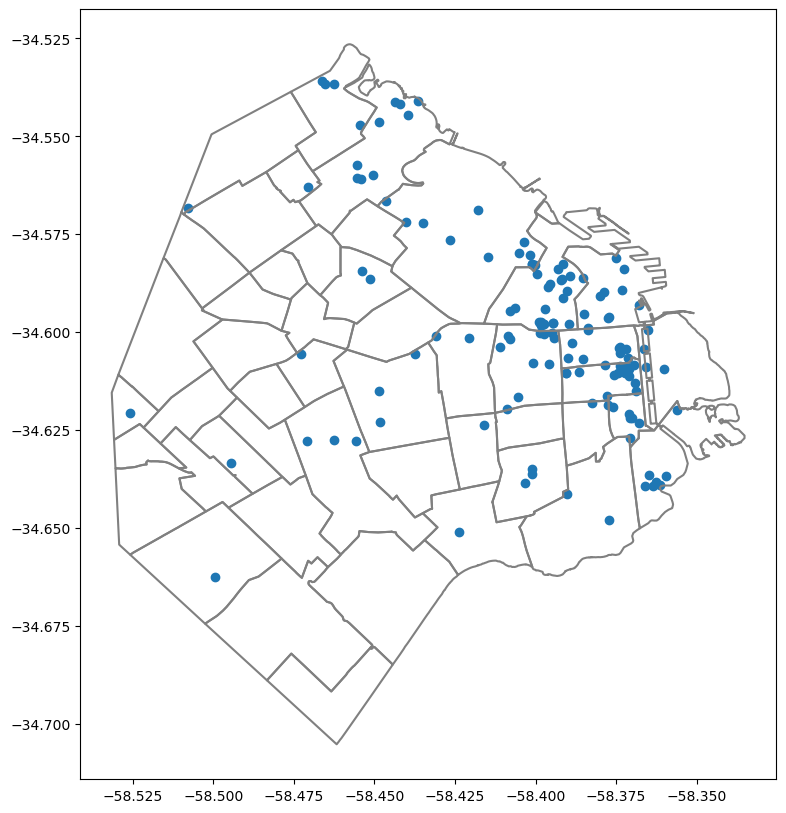

In [45]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [46]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [47]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [48]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

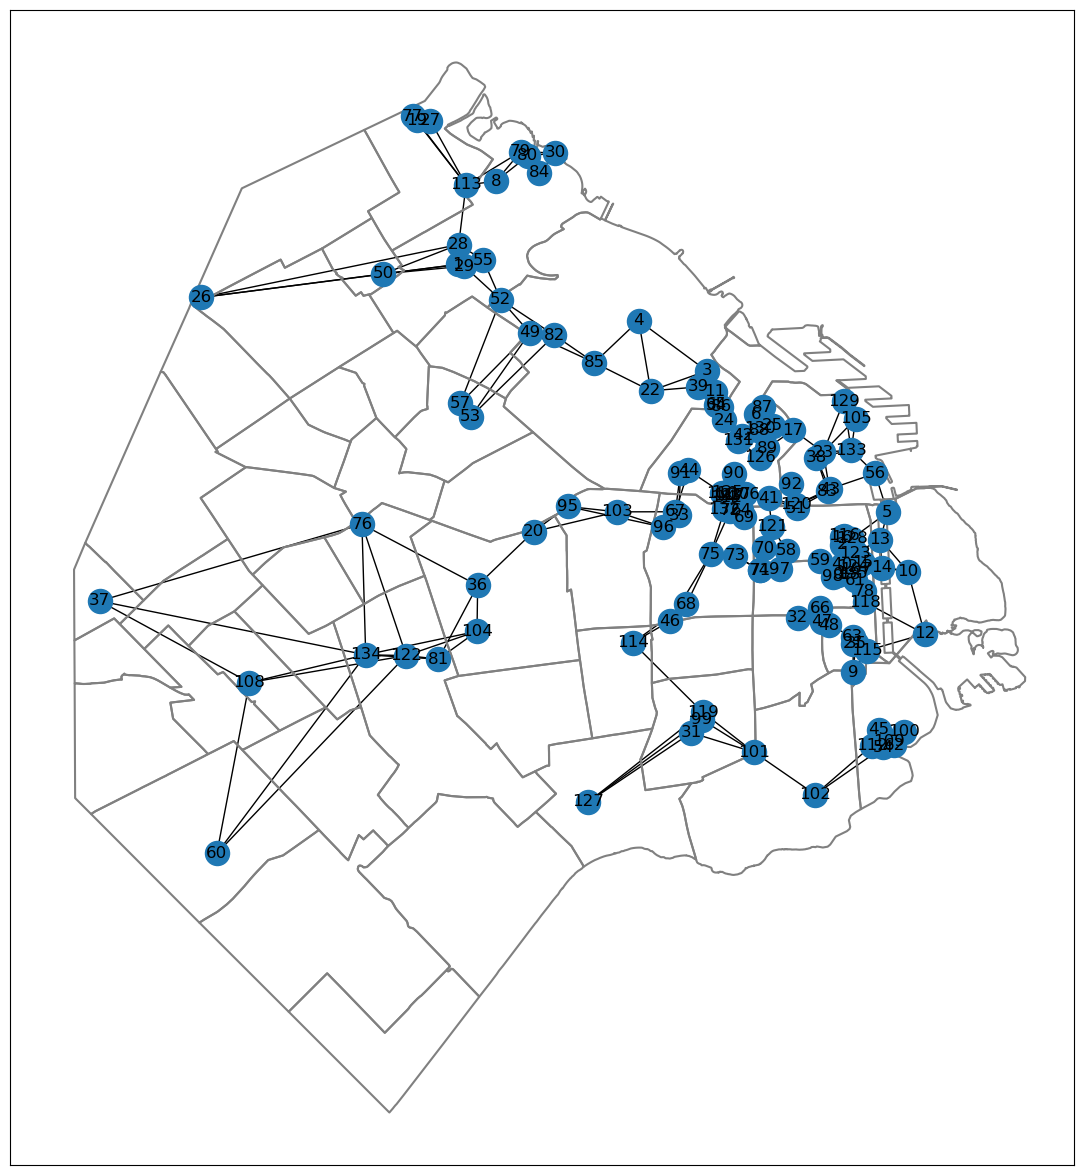

In [49]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Partamos de la ecuacion siguiente para llegar hacia Mp = b:

1.
$$
p = (1 - \alpha) \cdot C \cdot p + \frac{\alpha}{N} \cdot \mathbf{1}
$$
$$
0 = (1 - \alpha) \cdot C \cdot p - p + \frac{\alpha}{N} \cdot \mathbf{1}
$$
$$
- \frac{\alpha}{N} \cdot \mathbf{1} = (1 - \alpha) \cdot C \cdot p - p
$$
Aca sacamos factor comun usando p 
$$
- \frac{\alpha}{N} \cdot \mathbf{1} = ((1 - \alpha) \cdot C - I) \cdot p 
$$
$$
\frac{\alpha}{N} \cdot \mathbf{1} = -((1 - \alpha) \cdot C - I) \cdot p 
$$
$$
\frac{\alpha}{N} \cdot \mathbf{1} = (I - (1 - \alpha) \cdot C) \cdot p 
$$
$$
\mathbf{1} = \frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C) \cdot p   
$$
Por la definicion de M simplemente reemplazamos y llegamos a:
$$
\mathbf{1} = M \cdot p   
$$
9. Entonces llegamos a partir de la formula .1 a que el vector de rankings p es el resultado de Mp = b con b siendo 1 (vector de 1's) y M siendo igual a:
$$
\frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C)
$$

## Punto 2:


a) Para que Mp = b tenga una sola solucion entonces las columnas de M deberian ser Linealmente Independientes.

b) Sabemos que M es igual a:
$$
\frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C)
$$
Donde N sobre Alpha es un escalar donde N es el tamanio de C y Alpha un numero mayor y menor estricto de 0 y 1 respectivamente, por lo que lo que verdaderamente nos interesa ver para cerciorarnos de que la matriz M tiene solucion unica es la parte de:
$$
(I - (1 - \alpha) \cdot C)
$$
Lo que sabemos de esta parte de la formula es que el escalar de (1 - Alpha) es estrictamente mayor que 0 y menor que uno por la definicion de Alpha dada anteriormente. Luego, sobre C sabemos que es una matriz estocastica, esto quiere decir que la sumatoria de los valores de sus columnas es igual a 1 y que todo valor de la matriz C es positivo. Ahora bien, teniendo esta informacion como podriamos demostrar que la Matriz M tiene solucion unica?
De C, al ser estocastica, podemos deducir que al ser multiplicada por un escalar significa que todos los valores internos de C estan siendo multiplicados por un valor estrictamente menor que 1, por lo cual la matriz C multiplicada por el escalar (llamemosla B) tiene norma 1 estrictamente menor a 1. Esto radica en la definicion de matriz estocastica, donde la sumatoria de las columnas es exactamente 1 (por lo que tiene norma 1) por lo que ahora el valor de su norma al multiplicarla por un numero < 1 podemos asegurar que:
$$
\|\mathbf{B}\|_1 < 1
$$
Teniendo esto en cuenta, tratemos de definir por absurdo que el resultado de la resta (I-B) es inversible, es decir, que es LI y por lo tanto resultado unico de Mp = b.
Supongamos que el resultado de dicha resta NO es LI, esto significa que el Nucleo va a ser de una dimension mayor a 2 ya que vamos a tener mas valores ademas del x = 0 para los cuales:
$$
(I - B) \cdot \mathbf{x} = \mathbf{0} 
$$
Por lo tanto podemos asegurar que existe un x != 0 para el cual el resultado de dicha ecuacion es 0. Por lo cual podemos plantear que:
$$
(I - B)\cdot \mathbf{x} = \mathbf{0} 
$$ 
$$
I\cdot \mathbf{x} - B\cdot \mathbf{x} = 0 
$$ 
$$
\mathbf{x} - B\cdot \mathbf{x} = 0
$$
$$
\mathbf{x} = B\cdot \mathbf{x}
$$
Y terminamos llegando a una igualdad:
$$
\|\mathbf{x}\|_1 = \|\mathbf{Bx}\|_1 
$$
Por propiedad de normas, podemos definir que:
$$
\|\mathbf{Rx}\|_1 <= \|\mathbf{B}\|_1 \cdot \|\mathbf{x}\|_1 
$$
Y ahora reemplazamos
$$
\|\mathbf{x}\|_1 <= \|\mathbf{B}\|_1 \cdot \|\mathbf{x}\|_1 
$$
$$
1 <= \|\mathbf{B}\|_1
$$
ABSURDO! sabiamos que la norma de B era estrictamente menor que 1, este error se debe en que asumimos que (I-B) no era inversible, por lo que al demostrar que la matriz resultado de esta resta es inversible, podemos asegurar que M es inversible.

## Punto 3:

In [ ]:
#Seteamos las variables que sabemos que son globales y no cambian
N = A.shape[0]
I = np.eye(N, k=0)

#Funciones que utilizamos

# Esta función realiza eliminación gaussiana sin pivoteo para descomponer una matriz cuadrada A en L y U.
# Se recorre la matriz aplicando transformaciones fila por fila para anular los elementos por debajo de la diagonal.
# Los multiplicadores usados para eliminar elementos se almacenan directamente en la matriz.
# Finalmente, se extraen L (triangular inferior con unos en la diagonal) y U (triangular superior) a partir de la matriz transformada.

def elim_gaussiana(A):
    m=A.shape[0]
    n=A.shape[1]
    Ac = A.copy()
    
    if m!=n:
        print('Matriz no cuadrada')
        return
    
    for iteracion in range(n - 1):
        for fila in range(iteracion + 1, n):
            
            divisor = Ac[f][iteracion] / Ac[iteracion][iteracion]
            Ac[fila][iteracion] = divisor  
            
            for columna in range(iteracion + 1, n):  
                Ac[fila][columna] = Ac[fila][columna] - divisor * Ac[iteracion][columna]
            
    L = np.tril(Ac,-1) + np.eye(n)
    U = np.triu(Ac)
    
    return L, U

# Resuelve Ly = b, con L siendo matriz triangulada inferior

def y_calculator(L, b):
    return scipy.linalg.solve_triangular(L, b, lower=True)

# Resuelve Ux = y, con U siendo matriz triangulada superior

def x_calculator(U, y):
    return scipy.linalg.solve_triangular(U, y, lower=False)


def matriz_M(a,m):
    # Armamos K que es la identidad multiplicada por m, como necesitamos la inversa solamente calculamos la inversa de la diagonal
    K_inversa = np.eye(N, k=0)*(1/m)
    # Construimos A para el m seteado
    A_m = construye_adyacencia(D, m)
    A_transpueta = A_m.T
    
    C_m = A_transpueta @ K_inversa
    # Devolvemos la definicion de M 
    M = (N/a)*(I-(1-a)*C_m)
    return M

def ploteador(p, m):
    A_m = construye_adyacencia(D, m)
    G_m = nx.from_numpy_array(A_m) # Construimos la red a partir de la matriz de adyacencia
    G_m_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    # Construimos un layout a partir de las coordenadas geográficas
    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
    fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    p = p/p.sum() # Normalizamos para que sume 1
   
    Nprincipales = 3 # Cantidad de principales
    principales = np.argsort(p)[-Nprincipales:] # Identificamos a los N principales
    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
   
    nx.draw_networkx(G_m, G_m_layout, node_size = p*factor_escala, ax=ax, with_labels=False) # Graficamos red
    nx.draw_networkx_labels(G_m, G_m_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

def plot_page_rank_usando_m_o_alpha(set_museos, vectores_ranking, label_x, title, arguments_for_plot):
    plt.figure(figsize=(12,6))
    for museo in list(set_museos):
        valores_p = [p[museo] for p in vectores_ranking]
        plt.plot(arguments_for_plot, valores_p, marker='o', label=f'Museo {museo}')

    plt.xlabel(label_x)
    plt.ylabel("PageRank")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Aca seteamos los alpha's y m's para generar todas las matrices M que nos piden, luego vamos a obtener la 
# factorizacion LU de cada una y resolvemos con las funciones para las matrices trianguladas
# Tambien seteamos el vector b lleno de 1's

alpha_6_7 = 6/7
alpha_4_5 = 4/5
alpha_2_3 = 2/3
alpha_1_2 = 1/2
alpha_1_3 = 1/3
alpha_1_5 = 1/5
alpha_1_7 = 1/7

m_1 = 1
m_3 = 3
m_5 = 5
m_10 = 10

b = np.ones(N)

Por ultimo, antes de comenzar queremos aclarar demostrando QUE es lo que estamos implementando en codigo, o para que lo estamos realizando. el paso a paso es el siguiente:

## HACER DEMO MUY BOLUDA PARTIENDO DE C HASTA LLEGAR A P CON LAS FORMULITAS NADA MUY FANCY

## Punto 3) a)


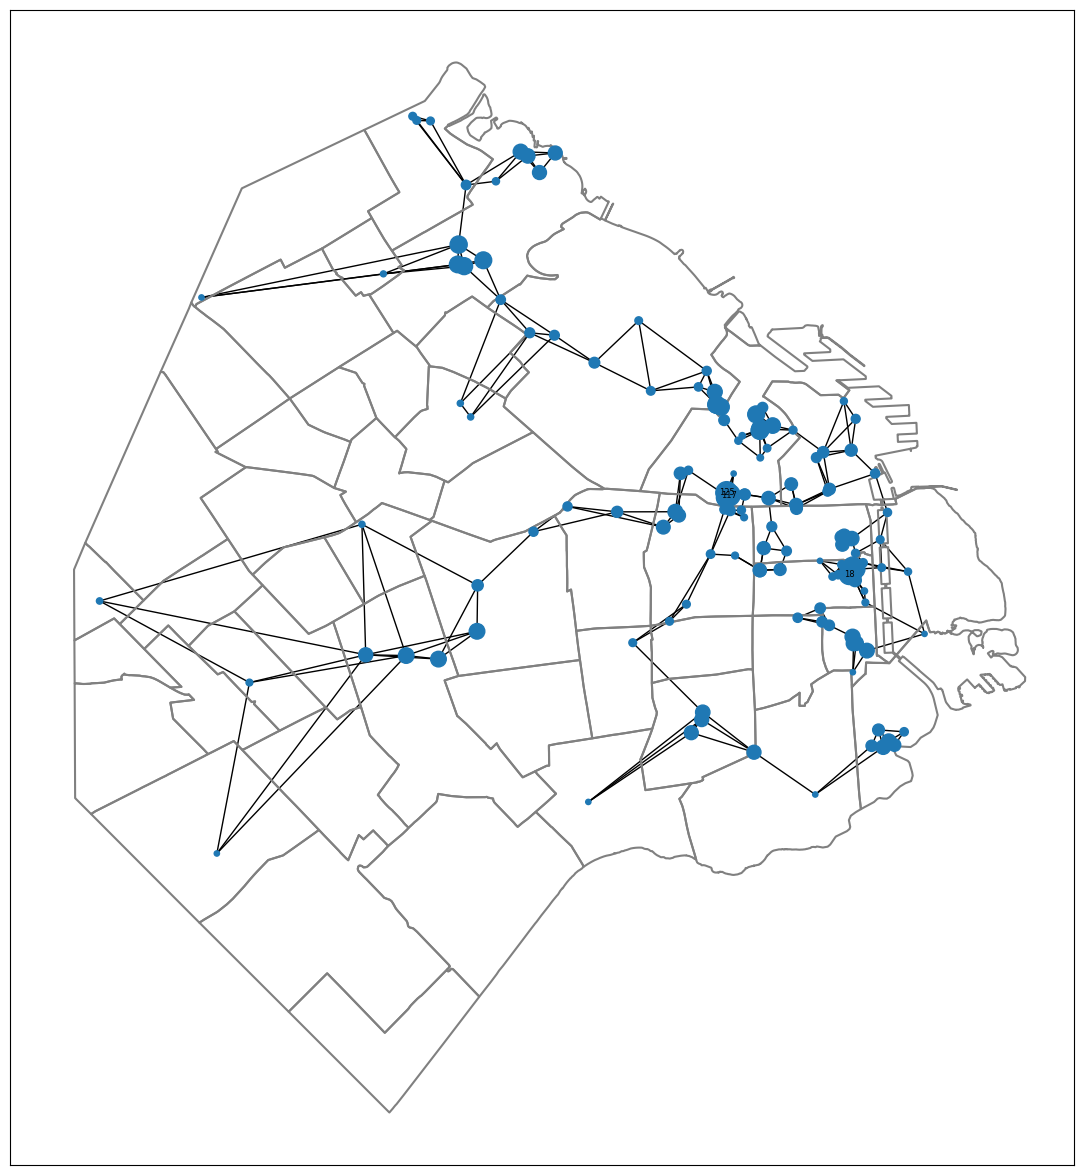

In [ ]:
#Ahora si, armamos la primer Matriz M pedida en a)

# Aca calculamos el M particular para el m y alpha fijos, calculamos su factorizacion LU y resolvemos las dos
# triangulaciones que nos quedan, finalmente lo ploteamos

M = matriz_M(alpha_1_5, m_3)
L, U = elim_gaussiana(M)
y = y_calculator(L, b)
p = x_calculator(U, y)
ploteador(p, m_3)



Lo que podemos observar a partir de dejar fijos los parametros m = 3 y alpha = 1/5 es que los museos con mayor PageRank son aquellos que se encuentran dentro de conglomerados de museos, esto tiene sentido ya que se debe a que las "referencias" de los museos son los 3 museos mas cercanos que tienen, esto se suma al hecho de que alpha tiene un valor bajo por lo que el valor del PageRank va a estar definido en mayor medida por la cercania del museo (reducimos la "aleatoreidad"). Es por eso que aquellos museos que se encuentran entre muchos otros se ven beneficiados.

## Punto 3) b) 

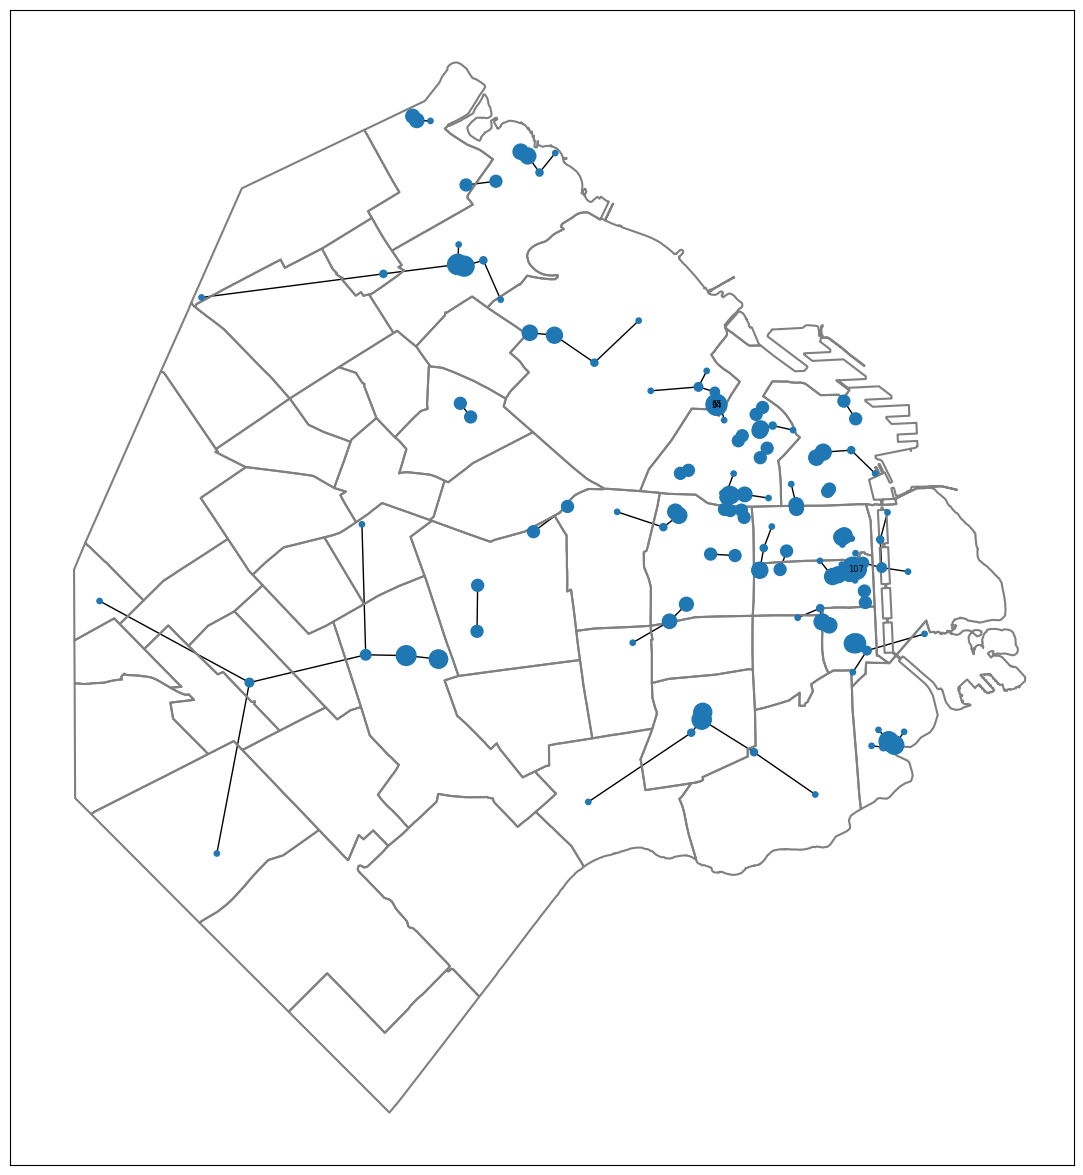

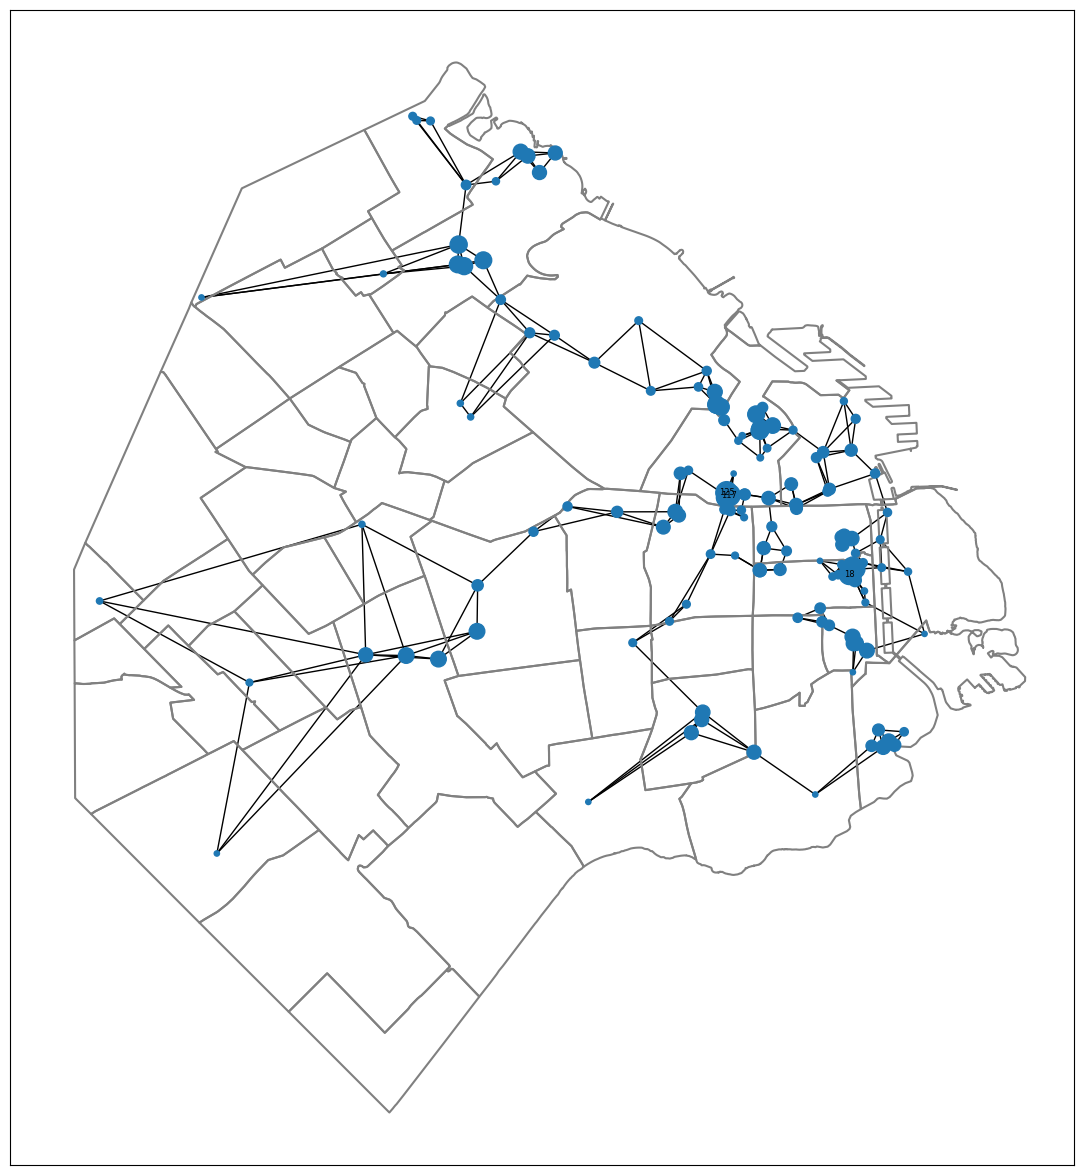

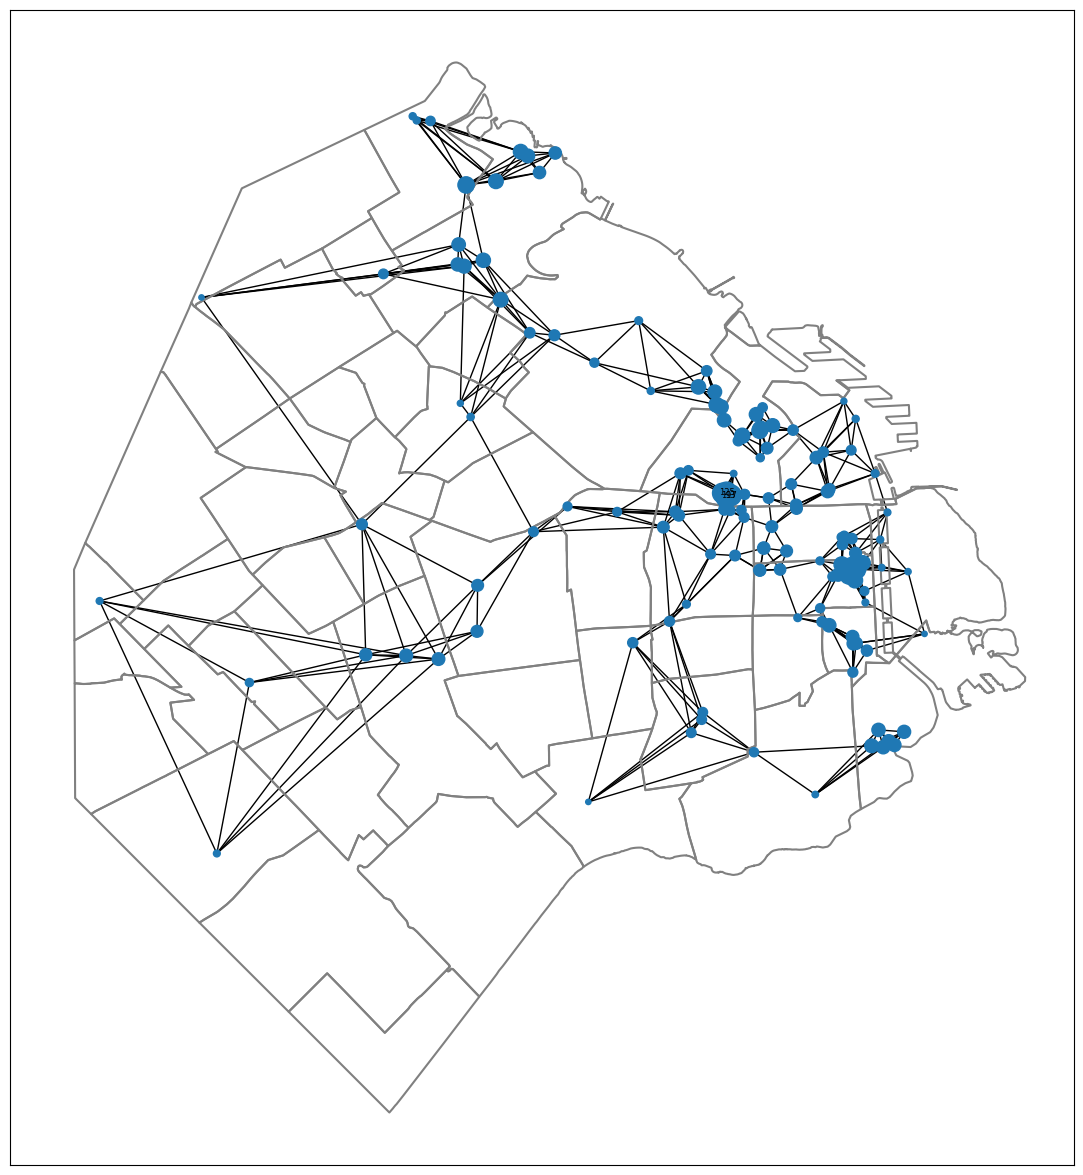

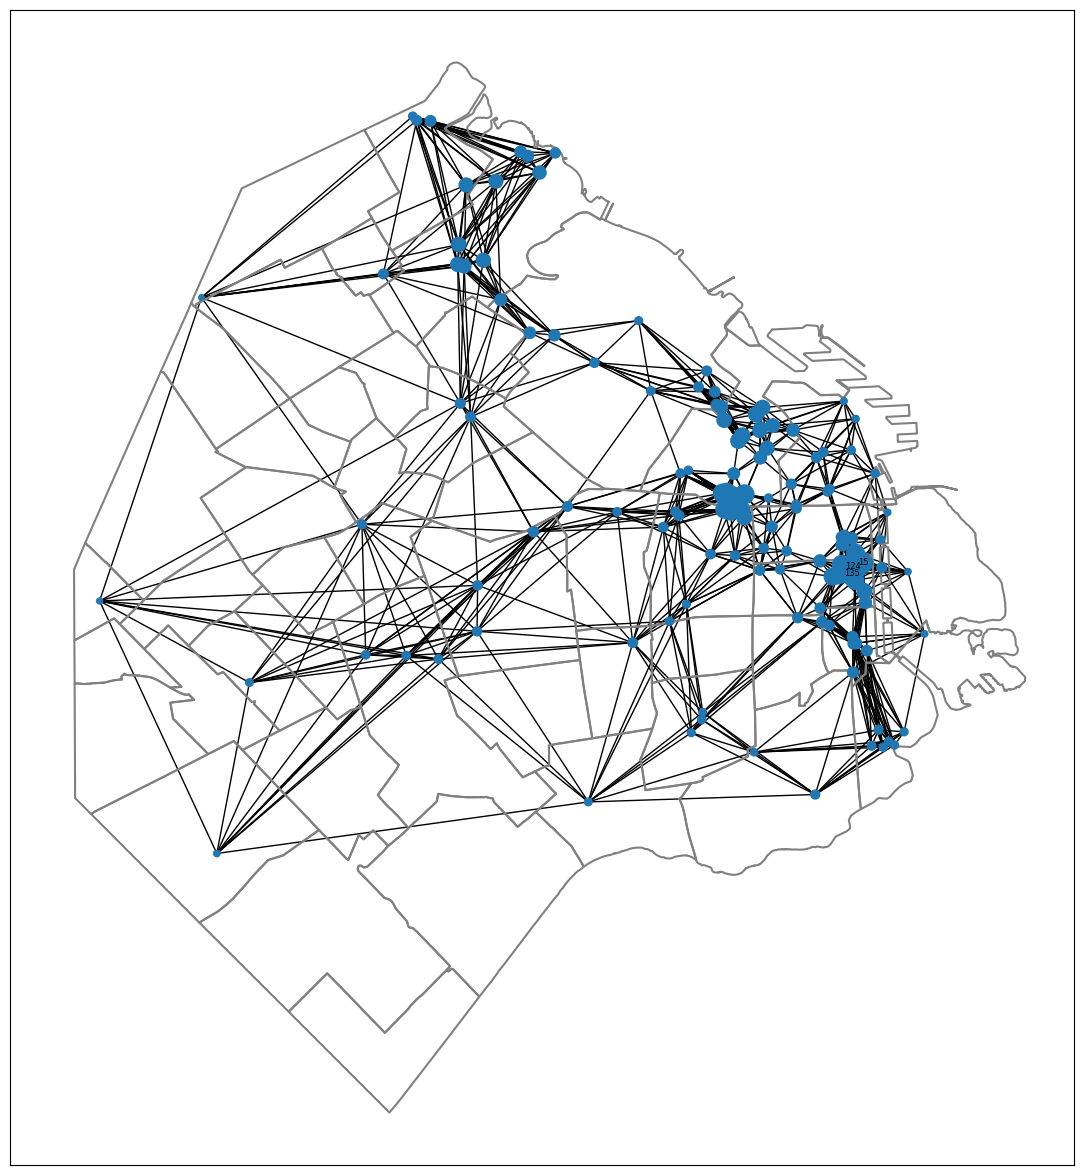

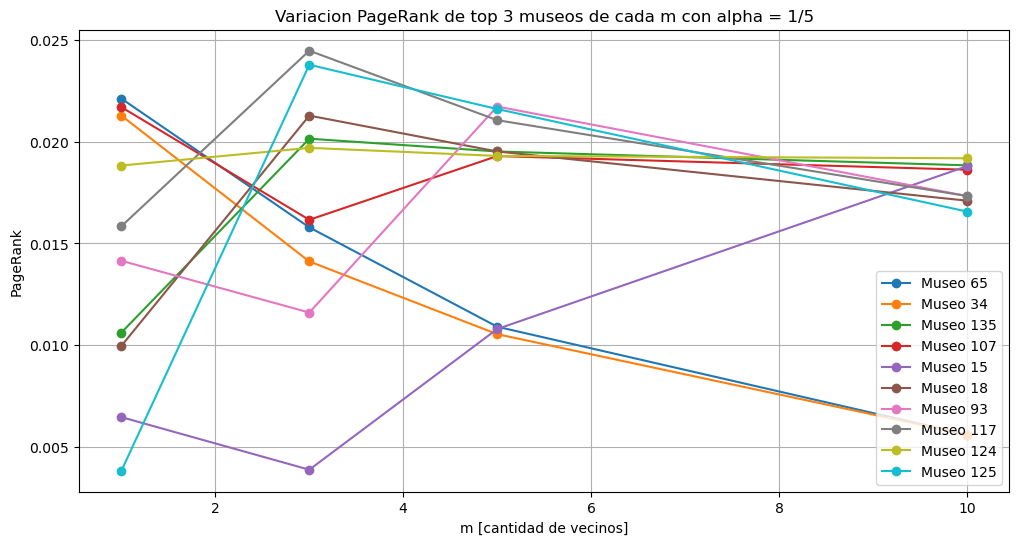

In [ ]:
#Aca ploteamos con alpha fijo en 1/5 y m variando en distintos valores (crecientes)
cant_vecinos_cercanos = [m_1, m_3, m_5, m_10]
vectores_p_page_ranking = []
set_museos = set() #conjunto para no tener repetidos


# Iteramos la lista de cantidad de vecinos mas cercanos (crecientes) y vamos resolviendo con factorizacion LU,
# luego ordenamos vector p para obtener los 3 mayores los cuales vamos a guardar en un conjunto para que no haya
# repetidos a la hora de plotearlos, luego armamos los titulos para nuestro metodo el cual dado los museos a
# plotear, los cuales son aquellos que alguna vez hayan estado en el top 3 para cualquier alpha, junto a su
# valor de PageRanking y su evolucion a medida que cambia m.

for m_value in cant_vecinos_cercanos:
    M = matriz_M(alpha_1_5, m_value)
    L, U = elim_gaussiana(M)
    y = y_calculator(L, b)
    p = x_calculator(U, y)
    
    ploteador(p,m_value)

    vectores_p_page_ranking.append(p)
    top3 = np.argsort(p)[-3:]  
    for i in range(3):
        set_museos.add(top3[i])
    
arguments_for_plot = [1,3,5,10]
label_m = 'm [cantidad de vecinos]'
title_m = 'Variacion PageRank de top 3 museos de cada m con alpha = 1/5'

plot_page_rank_usando_m_o_alpha(set_museos, vectores_p_page_ranking, label_m, title_m, vecinos)

Lo que podemos observar a partir de dejar fijo el parametros a = 1/5 y m quedando variable es que los valores de los mayores PageRank no varian  en valor, pero si varian los museos significativamente a medida que m cambia, los mayores PageRanks no permanecen estaticos a medida que m cambia.

Cuando m es bajo podemos ver es que los museos aledanios y que se apuntan mutuamente son los de mayor PageRank, y podemos ver que hay mucha diferencia entre los PageRanks de los distintos nodos viendo la disparidad de tamanio entre los mismos, los mayores PageRanks se forman en los museos en medio de grupos de museos cercanos ya que la cantidad de vecinos es baja y alpha tiene un valor relativamente bajo por lo que no hay tantas probabilidades de que el surfer se desvie de los museos mas cercanos

Cuando m es alto vemos que los 3 mayores PageRanks estan muy cercanos el uno del otro, esto se debe a que se encuentran en el medio de clusters de museos los cuales ahora son mucho mas amplios porque pueden recibir influencia de museos mas lejanos, esto da como resultado que los museos con mayor valor vayan cambiando radicalmente ya que no solamente se reciben "referencias" de los museos mas cercanos sino que tambien museos de grupos mas esparsos en la periferia. Tambien podemos observar que los valores de PageRank tienen una tendencia a permanecer igual cuando tienen un alpha bajo y varia m, lo que cambia son los museos con mayor valor.


## Punto 3) c)

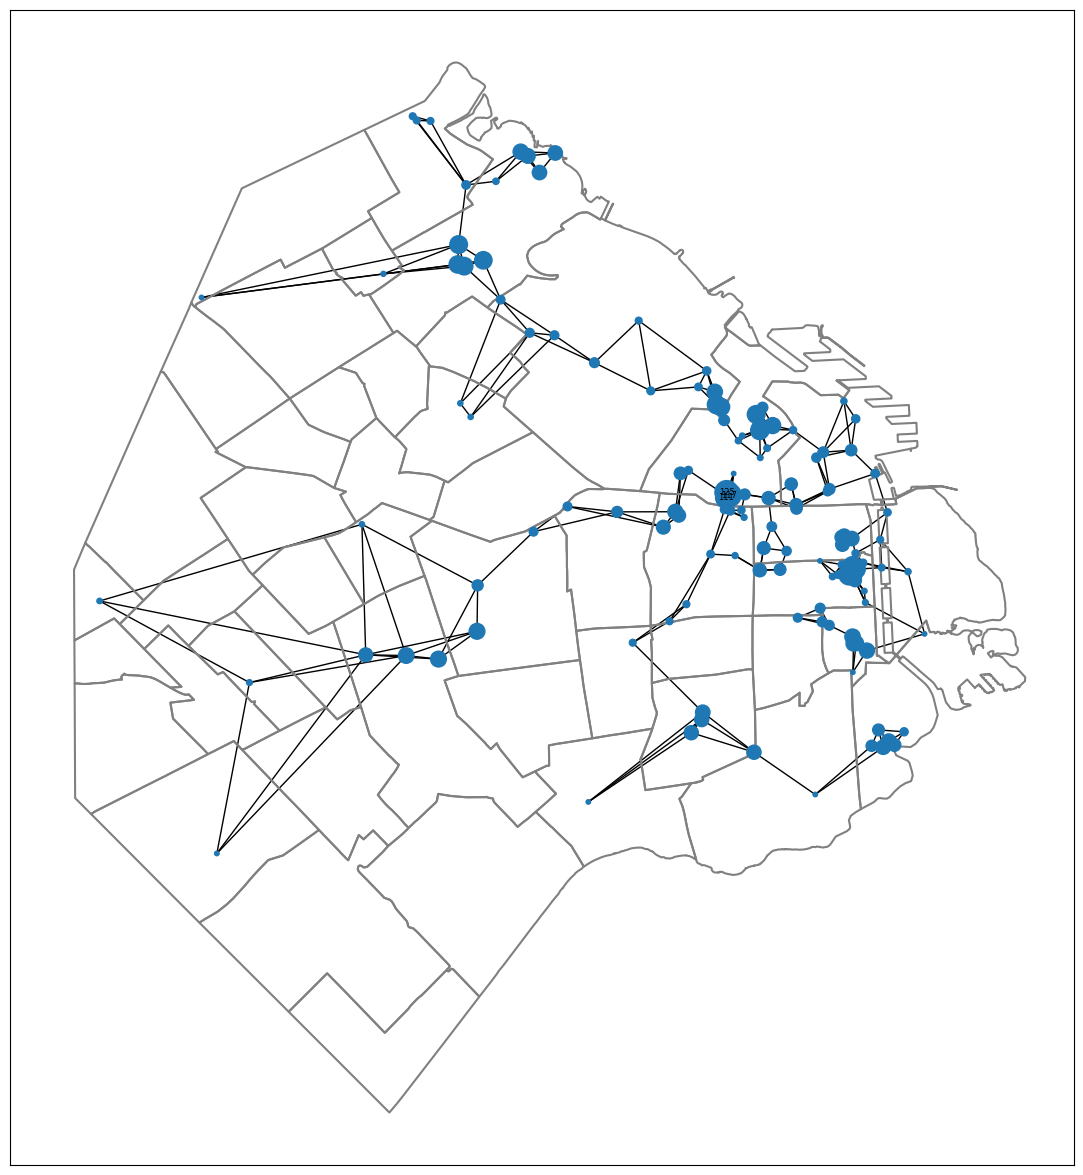

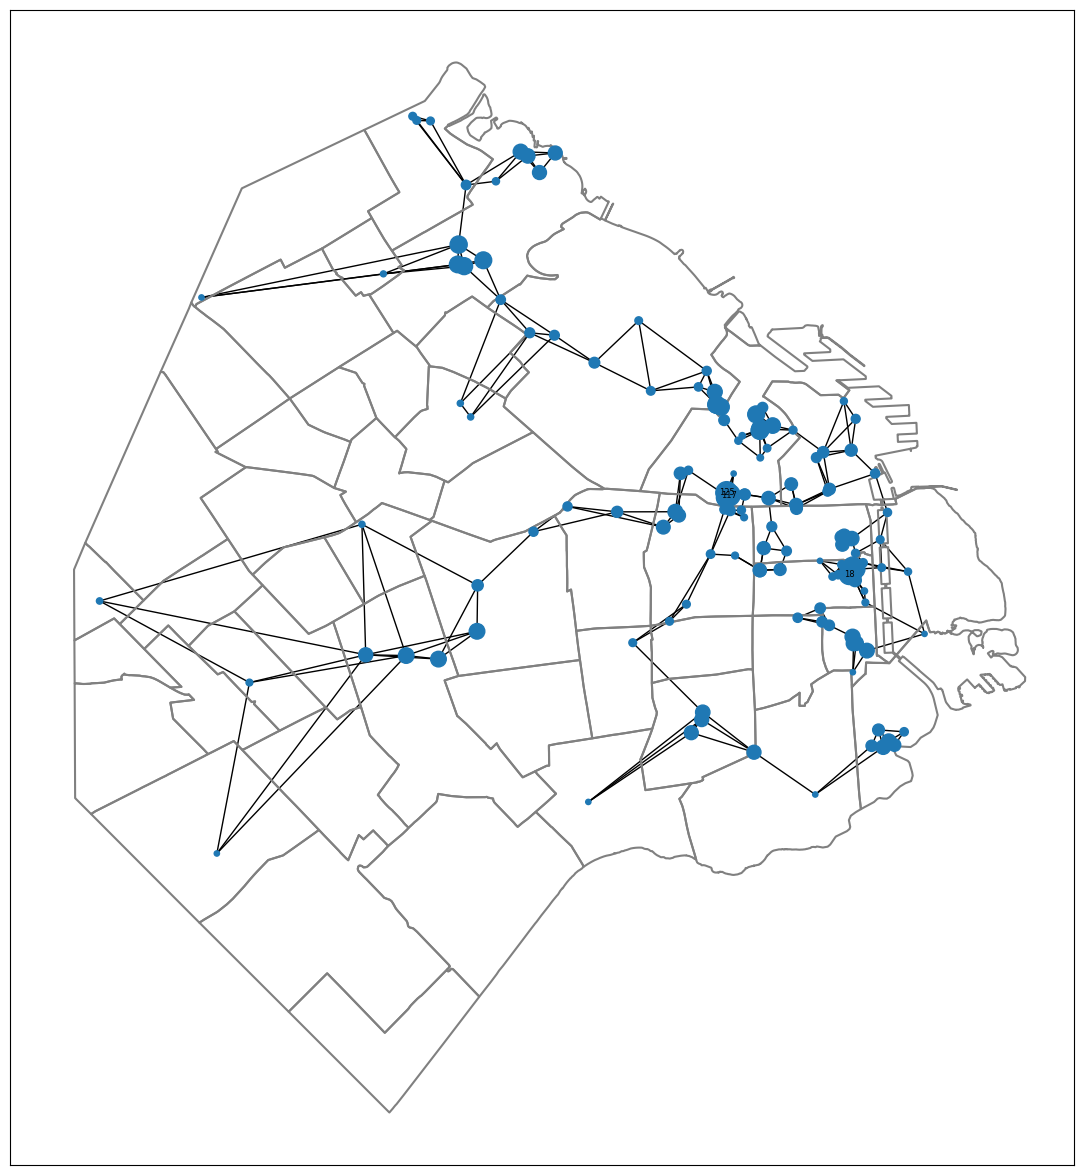

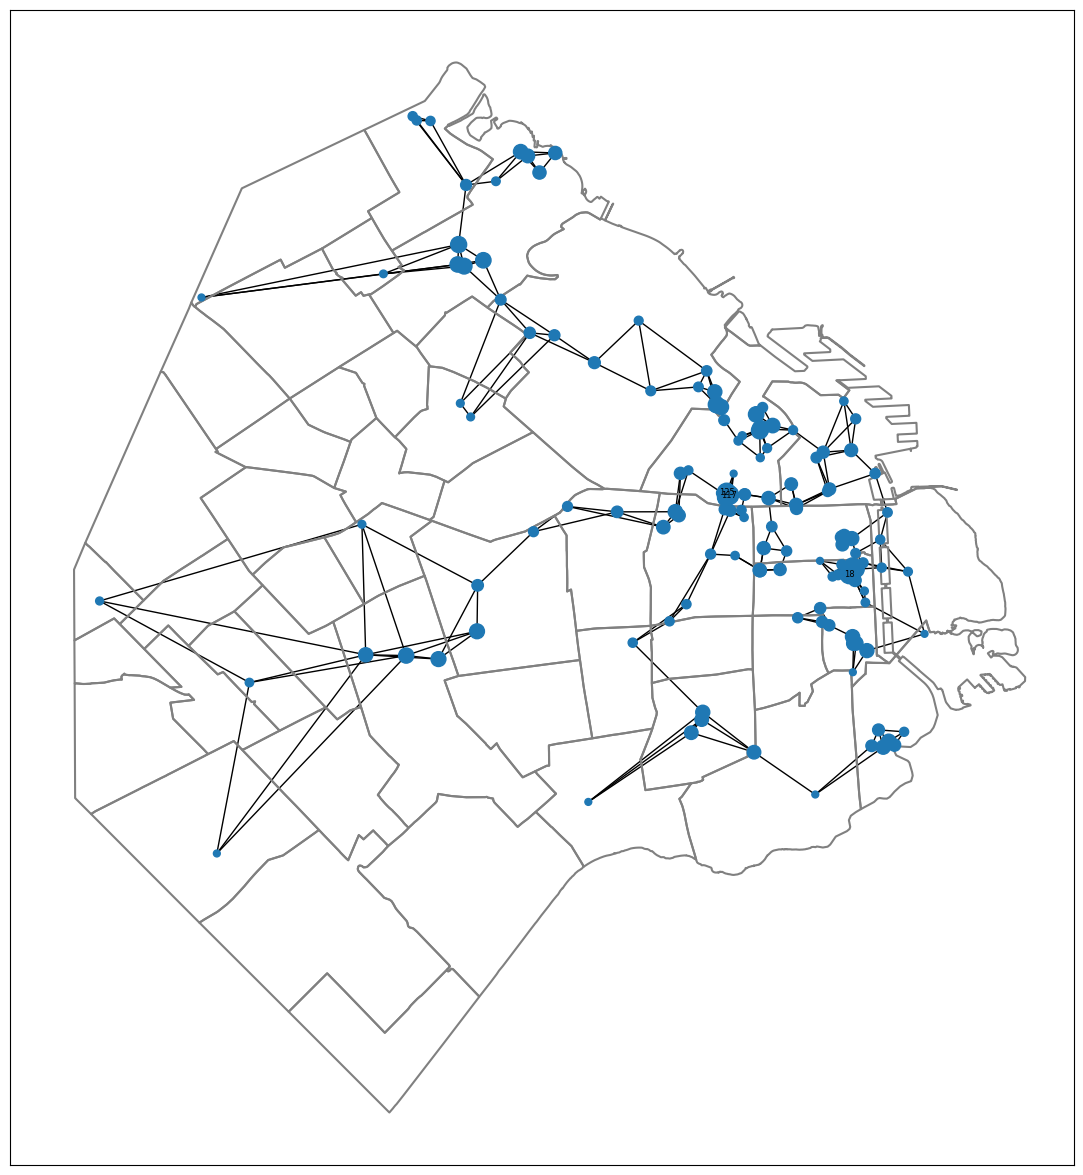

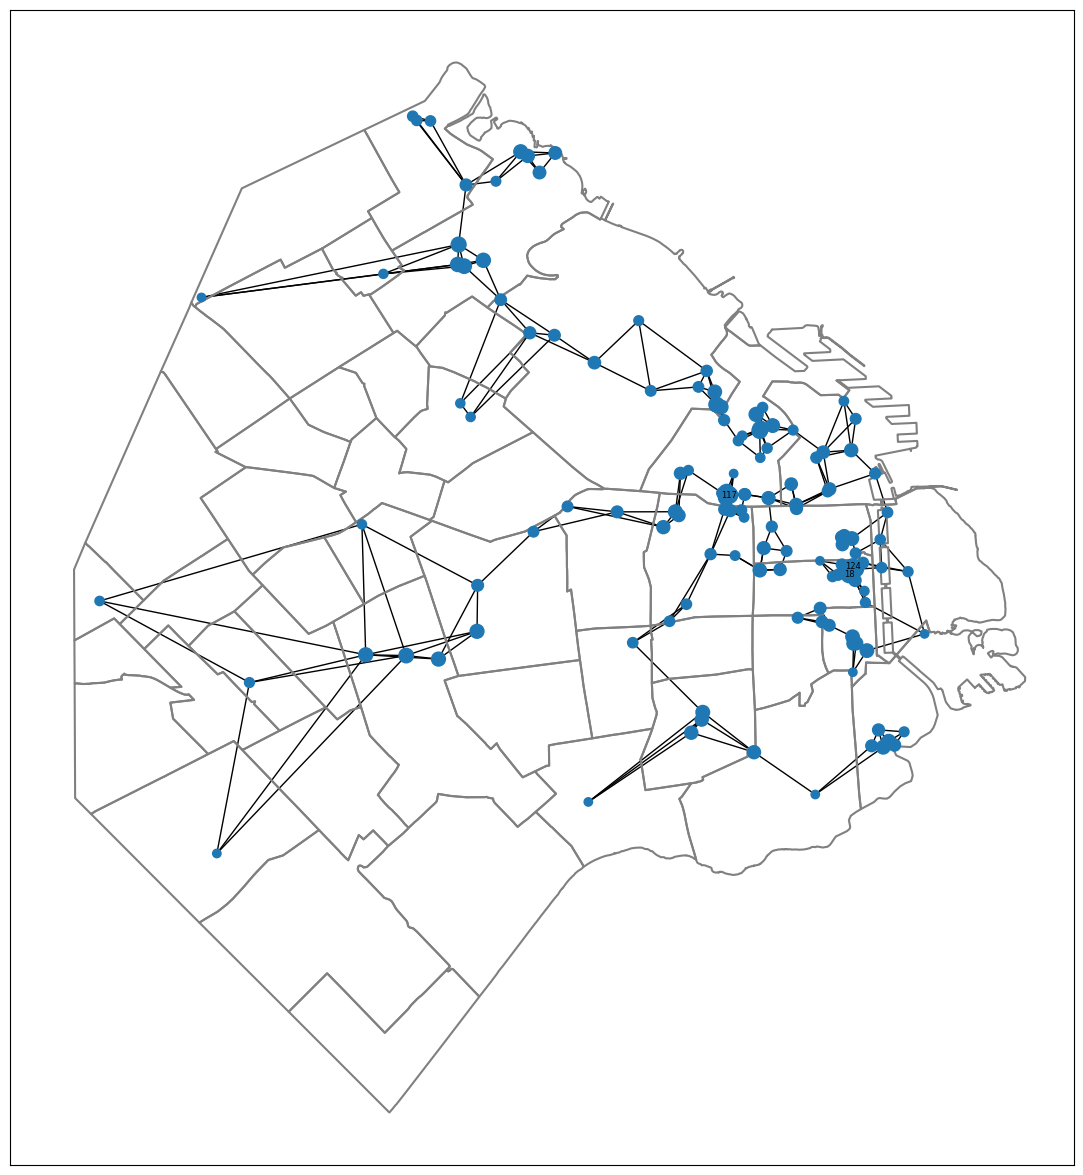

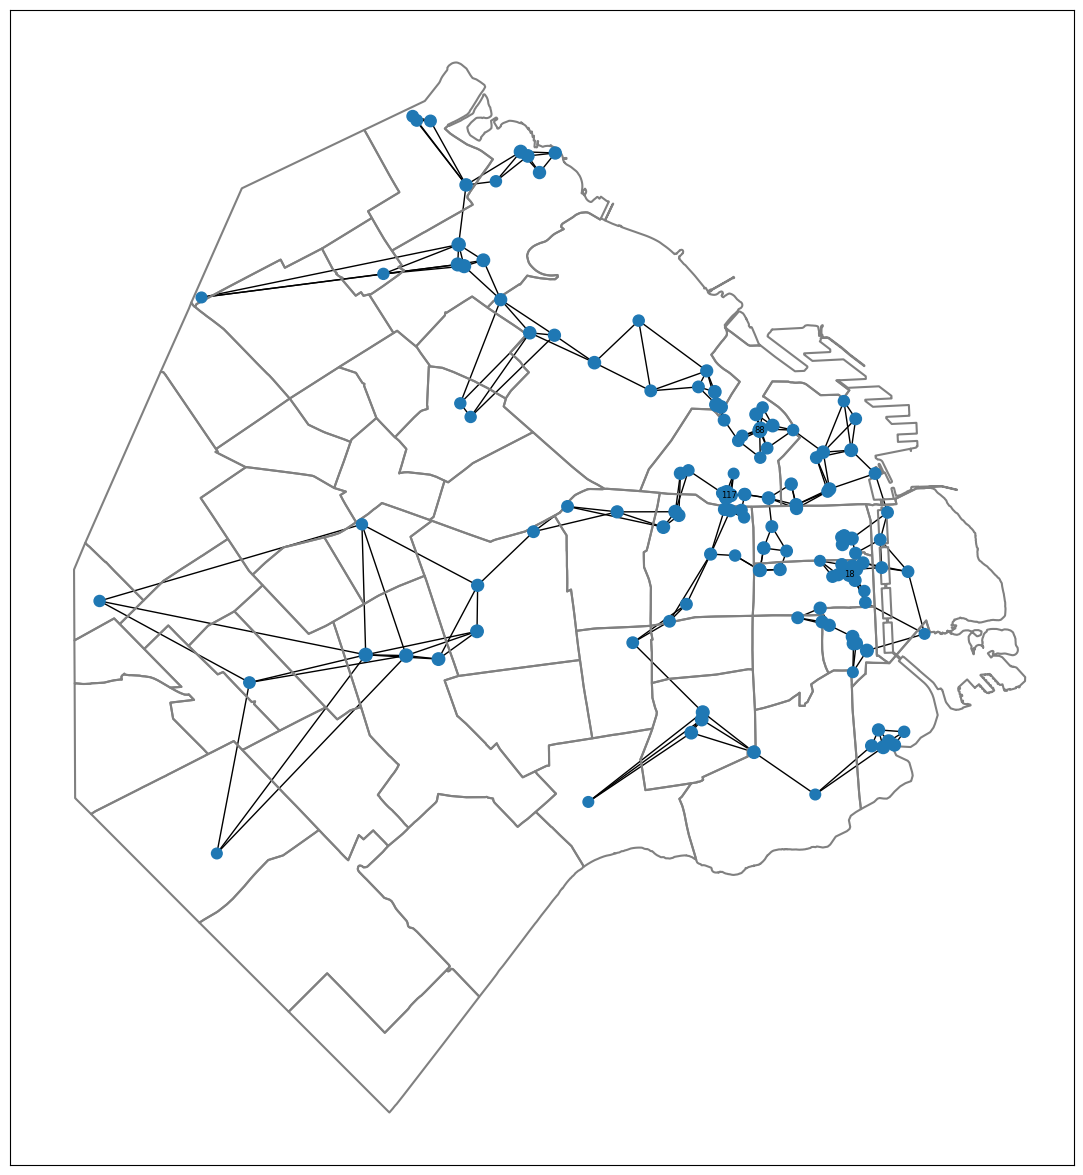

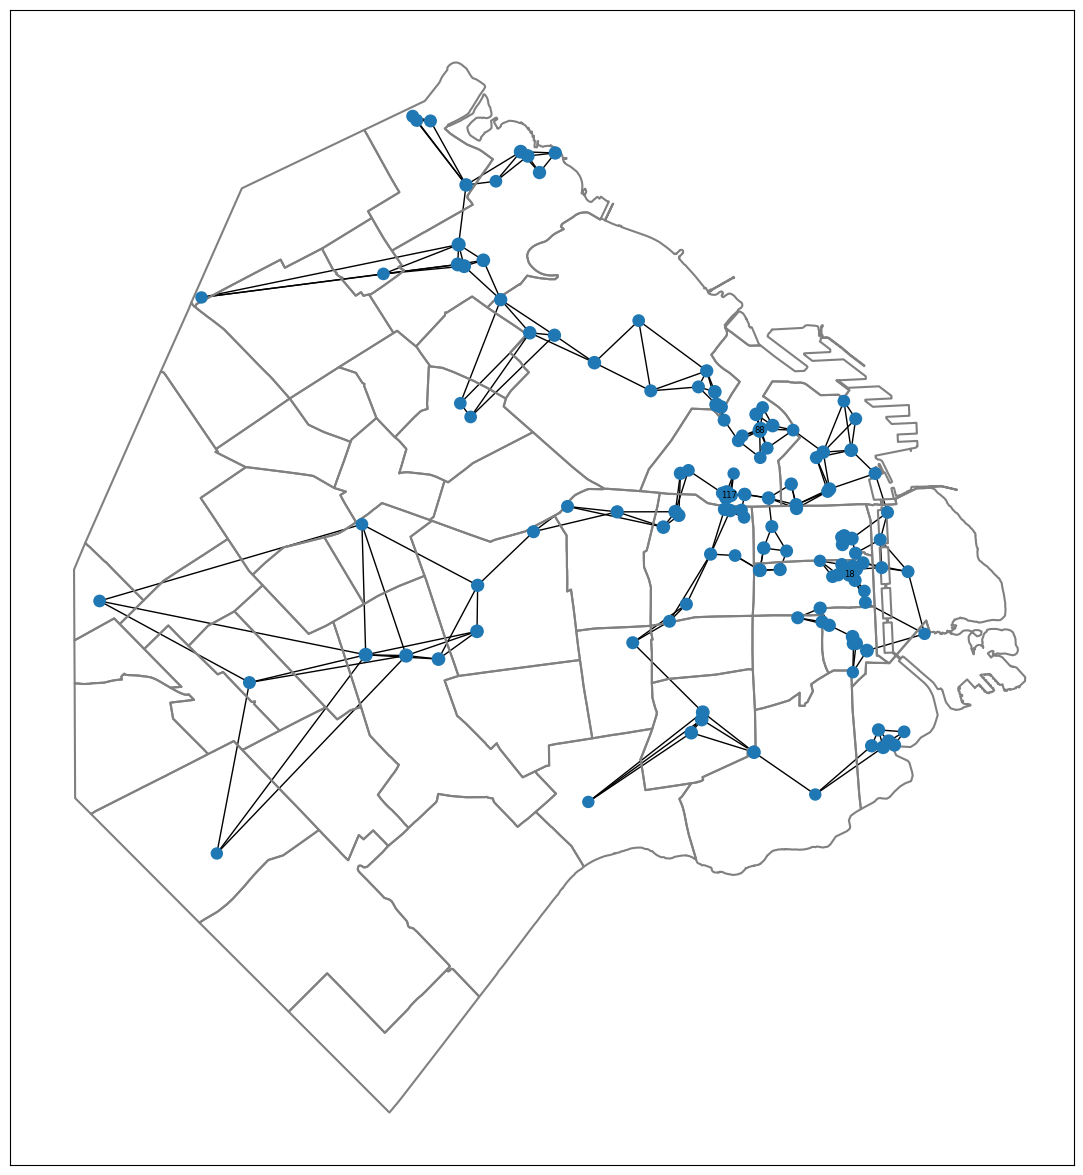

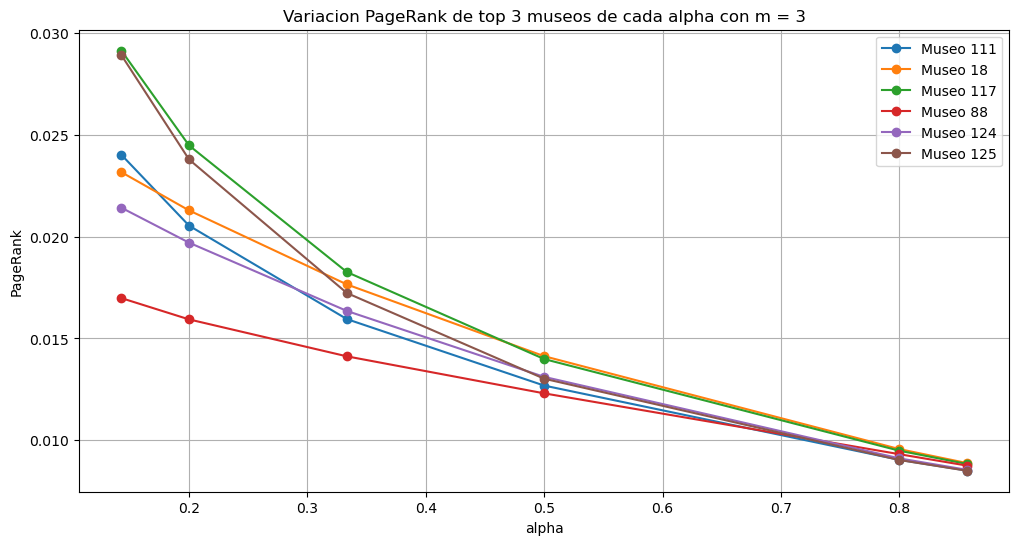

In [ ]:
#Aca ploteamos con m fijo en 3 y alpha variando en distintos valores (crecientes)
alphas = [alpha_1_7, alpha_1_5, alpha_1_3,  alpha_1_2, alpha_4_5, alpha_6_7]
vectores_p_page_ranking = []
set_museos = set()

# Iteramos la lista de alphas (crecientes) y vamos resolviendo con factorizacion LU, luego ordenamos vector p
# para obtener los 3 mayores los cuales vamos a guardar en un conjunto para que no haya repetidos a la hora
# de plotearlos, luego armamos los titulos para nuestro metodo el cual dado los museos a plotear, los cuales
# son aquellos que alguna vez hayan estado en el top 3 para cualquier alpha, junto a su valor de PageRanking
# y su evolucion a medida que cambia alpha.

for alpha in alphas:
    M = matriz_M(alpha, m_3)
    L, U = elim_gaussiana(M)
    y = y_calculator(L, b)
    p = x_calculator(U, y)
    ploteador(p, m_3)
    vectores_p_page_ranking.append(p)
    top3 = np.argsort(p)[-3:]  
    for i in range(3):
        set_museos.add(top3[i])

#Aca ya obtenemos los vectores de rankings p para los respectivos valores alpha y m = 3.

label_a = 'alpha'
title_a = 'Variacion PageRank de top 3 museos de cada alpha con m = 3'

plot_page_rank_usando_m_o_alpha(set_museos, vectores_p_page_ranking, label_a, title_a, alphas)

Lo que podemos observar a partir de dejar fijos el parametros m = 3 y alpha quedando variable es que se reducen los valores del PageRank a medida que alpha crece y m permanece en un valor bajo 

Cuando alpha tiene un valor bajo se puede observar en los mapas que los 3 museos con mayor PageRank tienen valores mayores (mayor tamanio) y estan juntos ya que se apuntan entre si, estos se debe a que la aleatoreidad de ir a un museo que no sea los 3 mas cercanos es baja por lo que el mayor PageRank se da en conglomerados. Esto tambien genera mucha mas disparidad en el PageRank resultante de los museos, tenemos maximos y minimos muy amplios (podemos verlo en el tamanio de los nodos)

A medida que alpha crece aumenta la aleatoreidad del 'surfer' y por lo tanto descentraliza los valores de PageRank de los conglomerados y se distribuye mucho mas uniformemente. En el ultimo ploteo podemos ver en el mapa que los 3 museos con mayor PageRank estan separados entre si y los valores generales de pageRank estan repartidos mucho mas equitativamente.  

## Punto 4:


$w$ = Vector que representa el número total de visitas que recibió cada museo en cada componente.  
$v$ = Vector que representa el número de visitas que recibió cada museo en el punto de partida.

Al realizar producto matricial con la matriz $C$ y el vector $v$, obtengo un vector $v_1$.  
Si se hace la misma aplicación sobre $v_1$ obtengo un $v_2$ con la información de los visitantes en una segunda iteración.  
Este procedimiento se puede repetir $k$ veces de modo que:

$$
v_k = C^k \cdot v
$$

(recordemos la propiedad de asociatividad $C(C \cdot v) = (C \cdot C) \cdot v$)

$w$, al representar el número total de visitas en $r$ iteraciones, se puede describir como la sumatoria de todos los $v$ (desde $0$ a $r-1$).  
Luego:

$$
w = \sum_{k=0}^{r-1} v_k
$$

Sea:

$$
B = \sum_{k=0}^{r-1} C^k
$$

Demostremos que:

$$
v = B^{-1} \cdot w
$$

$$
v = B^{-1} \cdot w \Leftrightarrow B \cdot v = w \Leftrightarrow \left( \sum_{k=0}^{r-1} C^k \right) \cdot v = \sum_{k=0}^{r-1} v_k
$$

pero $v_k = C^k \cdot v$, entonces:

$$
\sum_{k=0}^{r-1} C^k \cdot v = C^0 \cdot v + C^1 \cdot v + C^2 \cdot v + \dots + C^{r-1} \cdot v = (C^0 + C^1 + C^2 + \dots + C^{r-1}) \cdot v = \left( \sum_{k=0}^{r-1} C^k \right) \cdot v
$$


Por lo tanto:

$$
v = B^{-1} \cdot w \quad 
$$

## Punto 5:

Aca vamos a describir que pasos vamos a llevar a cabo en cada item del ejercicio, comenzando con el item a basicamente calculamos:
$$
C_{ji} = P(i \rightarrow j) = \frac{f(d_{ij})}{\sum_{\substack{k=1, k\ne i}}^{N} f(d_{ik})}
$$
Luego para item b, implementamos la siguiente formula para calcular B ahora que tenemos C a partir del item anterior
$$
B = \sum_{k=0}^{r-1} C^k
$$
y finalmente para el item c, factorizamos B para hallar:
$$
v = B^{-1} \cdot w \quad 
$$
Por lo que el procedimiento implementado para resolverlo fue el siguiente:
$$
B \cdot v = w
$$
$$
LU \cdot v = w
$$
$$
L \cdot y = w
$$
Resolvemos con el L triangulado para obtener w, y resolvemos:
$$
U \cdot v = y
$$
Resolvemos el sistema con U triangulado y finalmente obtenemos v, al cual si le calculamos la norma obtenemos lo que estabamos buscando, que era la cantidad de visitantes que entraron en la red


In [ ]:
#Seteamos variables globales que vamos a necesitar

vector_w = pd.read_csv('./visitas.txt', sep='\t', encoding='utf-8')
r=3
N = D.shape[0]

#Ejercicio a)

# En Calcula_matriz_C_continua(D) lo que hacemos es recorrer D (matriz de distancias de museos) para ir almacenando la sumatoria de las filas,
# luego le asignamos los valores a C donde debemos normalizarlos porque C es una matriz estocastica en filas donde debe almacenar en cada fila 
# la probabilidad de que un visitante en ese museo se mueva hacia alguno de los otros museos.

def calcula_matriz_C_continua(D):
    sumatoria_fila = 0
    C = np.zeros((N,N))

    for fila in range(N):
        for columna in range(N):
            if fila!=columna:
                sumatoria_fila += 1/D[fila][columna]
        for columna in range(N):
            if fila==columna:
                C[fila][columna] = 0 # Esto parece trivial porque C se inicializa en 0's pero es para aclarar regla del dominio de que no se  
                                     # pueden visitar un museo en el que ya se esta
            if fila!=columna:
                C[fila][columna] = (1/D[fila][columna])/sumatoria_fila # Normalizamos
        sumatoria_fila=0
    return C


# Ejercicio b)

# Esta función construye la matriz B como la suma de las potencias de C desde 0 hasta r-1.
# Conceptualmente, B representa la acumulación de probabilidades de que un visitante esté en cierto museo después de 0, 1, ..., r-1 pasos.
# Esta matriz es clave para estimar de dónde entraron originalmente los visitantes a la red.

def calcula_B(C,r):
    B = np.zeros((N,N))
    for k in range(r):
        B += np.linalg.matrix_power(C,k) 
    # Esta funcion es el equivalente a iterar haciendo C_k @ C, r veces (comenzando con C_k siendo la identidad porque k comienza en 0, C^k = I cuando k=0)
    return B

# Ejercicio c)

# Aca finalmente resolvemos directamente como vinimos haciendo anteriormente en el tp, con factorizacion LU en vez de invertir B, con su debida 
# justificacion arriba, las funciones son las definidas previamente tambien mas arriba en el trabajo. Luego resolvemos y obtenemos calculando
# norma 1 de el vector solucion v para obtener la cantidad de visitas

C = calcula_matriz_C_continua(D)
B = calcula_B(C,r)
L, U = elim_gaussiana(B)
y = y_calculator(L, vector_w)
v = x_calculator(U, y)

cantidad_visitas = np.linalg.norm(v, 1)

1159
0    1078
1    1137
2    1073
3    1097
4    1083
..    ...
130  1115
131  1110
132  1118
133  1156
134  1124

[135 rows x 1 columns]

NameError: name 'elim_gaussiana' is not defined

## Punto 6:

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

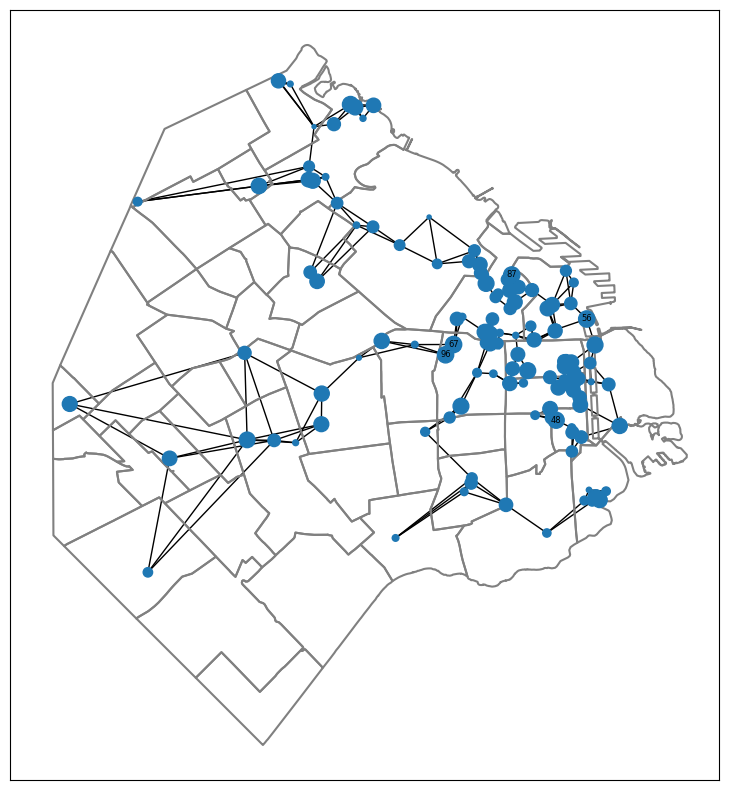

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres